In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("num of gpu available ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

num of gpu available  1


In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
import shutil
import random 
import warnings
warnings.filterwarnings('ignore')

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img


# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Miscellaneous
from tqdm import tqdm
import os
import random
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
#making test directory 
os.chdir('E:/Project/Deep learning/archive')
class_name = ['cataract','diabetic_retinopathy','glaucoma','normal']

#test folder
os.makedirs('test/cataract')
os.makedirs('test/diabetic_retinopathy')
os.makedirs('test/glaucoma')
os.makedirs('test/normal')

for i in range(len(class_name)):
    x = class_name[i]
    test_samples = random.sample(os.listdir(f'dataset/{x}'),200)
    for j in test_samples:
        shutil.move(f'dataset/{x}/{j}',f'test/{x}')
os.chdir('../..')

In [4]:
#reading_directories 
base_dir = r"E:\Project\Deep learning\archive\dataset"
test_dir = r"E:\Project\Deep learning\archive\test"

In [5]:
train_paths = []
train_labels = []

for label in os.listdir(base_dir):
    for image in os.listdir(base_dir+'//' +label):
        train_paths.append(base_dir + '//'+label+ '//'+image)
        train_labels.append(label)
        
train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)
        
test_paths, test_labels = shuffle(test_paths, test_labels)

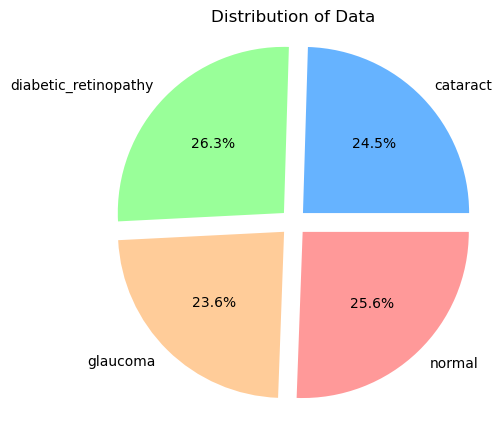

In [6]:
plt.figure(figsize=(5,5))
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
explode = (0.1, 0.1, 0.1, 0.1)
plt.pie([len(os.listdir(base_dir+"//" +label))
 for label in os.listdir(base_dir)],
    labels=os.listdir(base_dir),
    colors = colors,
    explode = (0.08,0.08,0.08,0.08),
    autopct='%1.1f%%',
 )
plt.title('Distribution of Data')
plt.axis('equal')
plt.show()

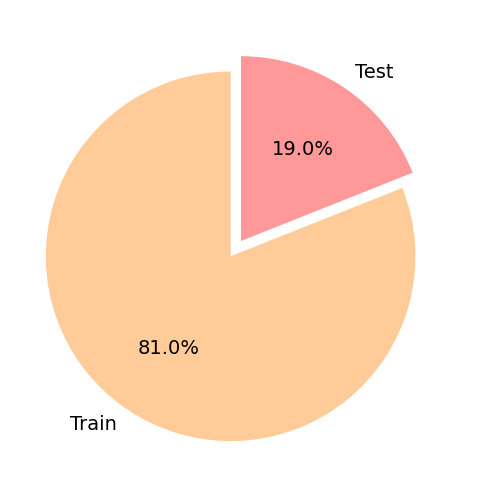

In [7]:
plt.figure(figsize=(14,6))
colors = ['#ffcc99', '#ff9999']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=colors, autopct='%.1f%%', explode=(0.1,0),
 startangle=90);

In [8]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

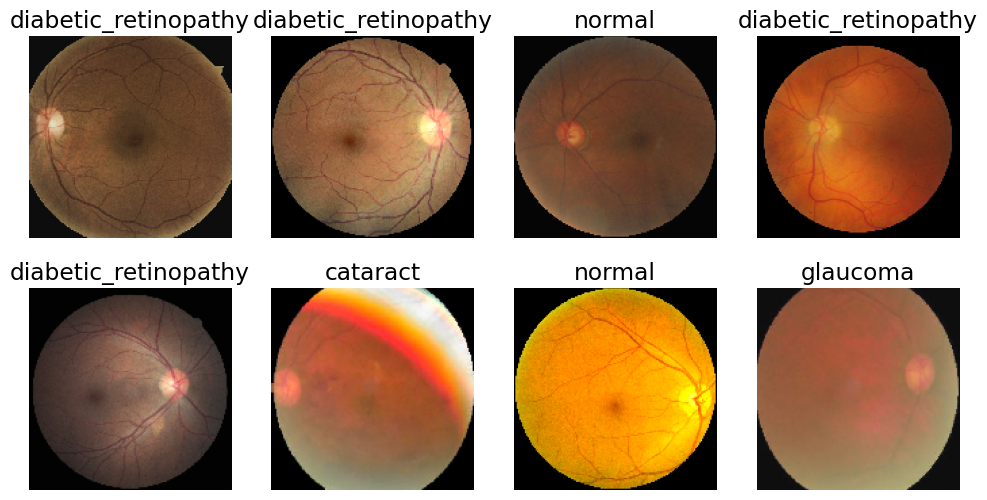

In [9]:
IMAGE_SIZE = 150
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [10]:
# unique_labels = glob( r"E:\Project\Deep learning\archive\dataset\*")
unique_labels = os.listdir(base_dir)

In [11]:
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=32, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

In [13]:
base_model = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)
for layer in base_model.layers:
     layer.trainable = False
        
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

In [14]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(256,activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(unique_labels),activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 16,845,508
Trainable params: 9,210,244
Non

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [17]:
Epochs = 10
BATCH_SIZE =32
steps = int(len(train_paths)/BATCH_SIZE)
history = model.fit(datagen
                    (train_paths, train_labels, batch_size=BATCH_SIZE, epochs=Epochs),
                    epochs=Epochs, 
                    steps_per_epoch=steps,
                    )

Epoch 1/10
106/106 [==============================] - 32s 220ms/step - loss: 1.9047 - sparse_categorical_accuracy: 0.4867
Epoch 2/10
106/106 [==============================] - 28s 221ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7640
Epoch 3/10
106/106 [==============================] - 23s 221ms/step - loss: 0.5548 - sparse_categorical_accuracy: 0.7979
Epoch 4/10
106/106 [==============================] - 23s 222ms/step - loss: 0.4631 - sparse_categorical_accuracy: 0.8298
Epoch 5/10
106/106 [==============================] - 23s 221ms/step - loss: 0.4029 - sparse_categorical_accuracy: 0.8576
Epoch 6/10
106/106 [==============================] - 24s 223ms/step - loss: 0.3547 - sparse_categorical_accuracy: 0.8718
Epoch 7/10
106/106 [==============================] - 24s 222ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8780
Epoch 8/10
106/106 [==============================] - 23s 222ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.8916
Epoch 9/10
106/106 [====

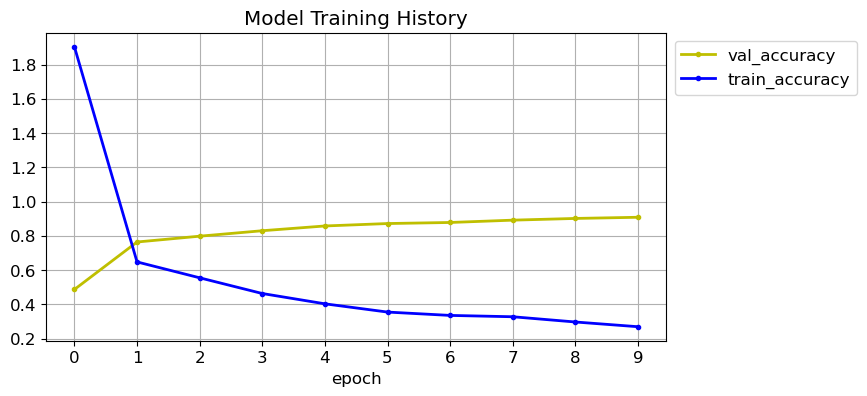

In [19]:
Epochs = 10
plt.figure(figsize=(8,4))
plt.grid(True) 
plt.plot(history.history['sparse_categorical_accuracy'], '.y-', linewidth=2)
plt.plot(history.history['loss'], '.b-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(Epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(['val_accuracy','train_accuracy', 'val_loss','train_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 250ms/step


  4%|███▎                                                                               | 1/25 [00:00<00:23,  1.03it/s]

1/1 [==============================] - 0s 16ms/step


  8%|██████▋                                                                            | 2/25 [00:01<00:13,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▉                                                                         | 3/25 [00:01<00:11,  1.93it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█████████████▎                                                                     | 4/25 [00:02<00:09,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                  | 5/25 [00:02<00:07,  2.61it/s]

1/1 [==============================] - 0s 25ms/step


 24%|███████████████████▉                                                               | 6/25 [00:02<00:06,  2.80it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████████████████▏                                                           | 7/25 [00:03<00:07,  2.27it/s]

1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████▌                                                        | 8/25 [00:03<00:06,  2.56it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▉                                                     | 9/25 [00:03<00:06,  2.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████████████████████████████████▊                                                 | 10/25 [00:04<00:06,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████████████████████████████████████                                              | 11/25 [00:04<00:05,  2.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|███████████████████████████████████████▎                                          | 12/25 [00:05<00:05,  2.41it/s]

1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:05<00:04,  2.64it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:05<00:04,  2.43it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:06<00:03,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:06<00:03,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:07<00:03,  2.41it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:07<00:02,  2.40it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:07<00:02,  2.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:08<00:01,  2.73it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:08<00:01,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:09<00:01,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:09<00:00,  2.40it/s]

1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:10<00:00,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.38it/s]


In [21]:
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

            cataract       0.86      0.93      0.89       200
diabetic_retinopathy       0.99      1.00      1.00       200
            glaucoma       0.87      0.75      0.81       200
              normal       0.81      0.84      0.83       200

            accuracy                           0.88       800
           macro avg       0.88      0.88      0.88       800
        weighted avg       0.88      0.88      0.88       800



# InceptionV3

In [30]:
base_model = InceptionV3(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)
for layer in base_model.layers:
     layer.trainable = False
        
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

In [31]:
model = Sequential()
model.add(base_model)
model.add(Flatten())


model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(len(unique_labels),activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               9437696   
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 4)                 516       
                                                                 
Total params: 31,306,660
Trainable params: 9,503,876
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
Epochs = 10
BATCH_SIZE =32
steps = int(len(train_paths)/BATCH_SIZE)
history = model.fit(datagen
                    (train_paths, train_labels, batch_size=BATCH_SIZE, epochs=Epochs),
                    epochs=Epochs, 
                    steps_per_epoch=steps,
                    )

Epoch 1/10
106/106 [==============================] - 27s 219ms/step - loss: 2.6534 - accuracy: 0.6002
Epoch 2/10
106/106 [==============================] - 23s 220ms/step - loss: 0.7760 - accuracy: 0.7279
Epoch 3/10
106/106 [==============================] - 23s 221ms/step - loss: 0.5384 - accuracy: 0.7997
Epoch 4/10
106/106 [==============================] - 23s 221ms/step - loss: 0.4771 - accuracy: 0.8127
Epoch 5/10
106/106 [==============================] - 23s 220ms/step - loss: 0.3782 - accuracy: 0.8538
Epoch 6/10
106/106 [==============================] - 23s 219ms/step - loss: 0.3334 - accuracy: 0.8736
Epoch 7/10
106/106 [==============================] - 23s 219ms/step - loss: 0.2715 - accuracy: 0.8922
Epoch 8/10
106/106 [==============================] - 23s 220ms/step - loss: 0.2598 - accuracy: 0.9052
Epoch 9/10
106/106 [==============================] - 23s 219ms/step - loss: 0.2492 - accuracy: 0.9022
Epoch 10/10
106/106 [==============================] - 23s 218ms/step - l

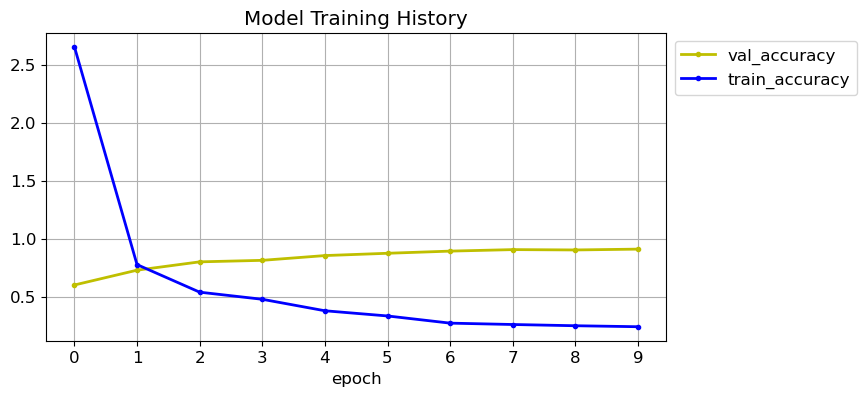

In [35]:
Epochs = 10
plt.figure(figsize=(8,4))
plt.grid(True) 
plt.plot(history.history['accuracy'], '.y-', linewidth=2)
plt.plot(history.history['loss'], '.b-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(Epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(['val_accuracy','train_accuracy', 'val_loss','train_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [36]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  4%|███▎                                                                               | 1/25 [00:01<00:40,  1.69s/it]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                            | 2/25 [00:01<00:19,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█████████▉                                                                         | 3/25 [00:02<00:13,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▎                                                                     | 4/25 [00:02<00:10,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▌                                                                  | 5/25 [00:02<00:07,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▉                                                               | 6/25 [00:03<00:06,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 28%|███████████████████████▏                                                           | 7/25 [00:03<00:07,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 32%|██████████████████████████▌                                                        | 8/25 [00:03<00:06,  2.75it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▉                                                     | 9/25 [00:04<00:05,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████████████████████████████████▊                                                 | 10/25 [00:04<00:05,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████████████████████████████████████                                              | 11/25 [00:05<00:05,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 48%|███████████████████████████████████████▎                                          | 12/25 [00:05<00:04,  2.61it/s]

1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:05<00:04,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:06<00:04,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:06<00:03,  2.63it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:06<00:03,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:07<00:03,  2.59it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:07<00:02,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:07<00:02,  2.80it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:08<00:01,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:08<00:01,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:08<00:01,  2.94it/s]

1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:09<00:00,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:09<00:00,  2.50it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.44it/s]


In [37]:
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

            cataract       0.92      0.94      0.93       200
diabetic_retinopathy       0.96      0.79      0.87       200
            glaucoma       0.80      0.67      0.73       200
              normal       0.63      0.84      0.72       200

            accuracy                           0.81       800
           macro avg       0.83      0.81      0.81       800
        weighted avg       0.83      0.81      0.81       800

